In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from database_methods import Table, to_show, head

from global_var import *
import sqlite3
con = sqlite3.connect('database_results.db')
cursor = con.cursor()

folder_save = 'C:/SPRUP_data_Jenda/2019_03_13_Jenda_microscopy/jupyter_figures/'

In [8]:
matplotlib.rc('font', family='serif') 
matplotlib.rc('font', serif='Palatino Linotype') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 20})

In [55]:
def spr_spectrum(folder, what = 'q'):
    main_folder='C:/SPRUP_data_Jenda/2019_03_13_Jenda_microscopy/'
    with open(main_folder + folder+'spectra_{}.txt'.format(what)) as f:
        infolist = f.read()
        info = []
    for i in infolist.split('\n')[:-1]:
        info.append([float(j) for j in i.split('\t')])
    intensity = [] 
    wlength = []
    for row in info:
        wlength.append(row[4])
        intensity.append(row[5])
    return wlength, intensity

def load_sql(sql_data, columns):
    col = columns.split(', ')

    data = dict()
    for c in col:
        data[c] = []

    for row in sql_data:
        i = 0
        for r in row:
            data[col[i]].append(r)
            i+=1
    return data

def add_spr(axesspr, name):
    wlength, intensity = spr_spectrum(name)
    wlength_pbs, intensity_pbs = spr_spectrum(name, 'pbs')
    axessen = axesspr.twinx()
    
    if len(intensity) > len(intensity_pbs): length = len(intensity_pbs)
    else: length = len(intensity)
        
    sensitivity = [(intensity_pbs[i] - intensity[i])/0.005 for i in range(length )]
    
    for tick in axesspr.get_yticklines():
        tick.set_visible(False)

    for tick in axesspr.get_yticklabels():
        tick.set_visible(False)
        
    for tick in axessen.get_yticklines():
        tick.set_visible(False)

    for tick in axessen.get_yticklabels():
        tick.set_visible(False)
        
    axessen.plot(wlength, intensity, linewidth=2, color=gray, label='spectrum', ls = ':')  
    
    axesspr.plot(wlength_pbs, sensitivity, color=red, label='sensitivity', ls = ':')  
    
def data_about_master(master):
    columns = 'MASTER, WAVELENGTH, CON, INP, IBGPX, INPPX, RATE, COUNT'
    sql_data = con.execute("""
    SELECT {}
    FROM 'masters' as MAS 
    INNER JOIN 'experiments' as EXP 
    ON MAS.ID = EXP.MASTER_ID
    INNER JOIN 'measurements' as MEAS
    ON EXP.ID = MEAS.EXPERIMENT_ID
    WHERE MASTER = '{}' AND EXP_TYPE='-' AND NP=80 AND DATE IS NOT '20-04-20' 
    ORDER BY WAVELENGTH ASC
    ;
       """.format(columns, master))
    
    sql_folder = con.execute("""
    SELECT FOLDER
    FROM 'masters' as MAS 
    INNER JOIN 'experiments' as EXP 
    ON MAS.ID = EXP.MASTER_ID
    WHERE MASTER = '{}';
       """.format(master))
    
    return load_sql(sql_data, columns), [s[0] for s in sql_folder][0]

def plot_spectrum(data, folder):
    fig, axes = plt.subplots()  
#     axes.set_title('SPECTRUM')
#     axes.set_title('(a)')
    axes.set_xlabel('$\lambda$ [nm]')
    axes.set_ylabel('R')
#     axes.grid(linestyle='--')
    
    wlength, intensity = spr_spectrum(folder)
    wlength_pbs, intensity_pbs = spr_spectrum(folder, 'pbs')
    
    if len(intensity) > len(intensity_pbs): length = len(intensity_pbs)
    else: length = len(intensity)
        
    sensitivity = [(intensity_pbs[i] - intensity[i])/0.005 for i in range(length )]
    
        
    axes.plot(wlength, intensity, linewidth=2, color=gray, label='water')  
    axes.plot(wlength_pbs, intensity_pbs, color=red, label='PBS') 
    
    location = mpatches.Rectangle(
                    (743, 0), 
                    1/10, 
                    axes.get_ylim()[1], 
                    color = black
                    )      
    
    location = mpatches.Rectangle(
                    (743, 0), 
                    1/10, 
                    axes.get_ylim()[1], 
                    color = black
                    ) 
        
    axes.add_patch(location)
    index_w = [int(round(w)) for w in wlength].index(743)
    index_wpbs = [int(round(w)) for w in wlength_pbs].index(743)
    
    print(wlength[index_w])
    print(wlength_pbs[index_wpbs])
    print(intensity[index_w])
    print(intensity_pbs[index_wpbs])

    lgd = fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.legend(loc=3, bbox_to_anchor=(0.15, 0.2, 1, 1))
#     fig.savefig(folder_save + 'plot_spectrum_'+ data['MASTER'][0] +'.png', dpi=300, bbox_inches='tight') 
    fig.savefig(folder_save + 'reflectivity_change'+ data['MASTER'][0] +'.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')    
    


In [25]:
mas = Table(connection=con, name='masters')
exp = Table(con, name = 'experiments')
meas = Table(con, name = 'measurements')

In [26]:
print(mas.columns)
print(exp.columns)
print(meas.columns)

CATEGORY, PERIOD, AMPLITUDE, MASTER, FWHM, R, S
DATE, MASTER_ID, DIP, FOLDER
EXPERIMENT_ID, NP, WAVELENGTH, FILE, AR_TH, AR_DIP, AR_NOISE, EXC_THS, RATE, INFO, COUNT, X, Y, CON, INP, INPPX, IBGPX, STD, stdX, stdY, stdCON, stdINP, stdINPPX, stdIBGPX, stdSTD, NOTES, AR_MIN, AR_COND, EXP_TYPE, OPT


In [27]:
# 
columns = 'MASTER, NP, WAVELENGTH, S, R, CON, INP, INPPX, IBGPX, EXP_TYPE'
data = con.execute("""
SELECT {}
FROM 'masters' as MAS 
INNER JOIN 'experiments' as EXP 
ON MAS.ID = EXP.MASTER_ID
INNER JOIN 'measurements' as MEAS
ON EXP.ID = MEAS.EXPERIMENT_ID
WHERE EXP_TYPE='-' AND WAVELENGTH = 745 AND DATE IS NOT '20-04-20' 
ORDER BY CON DESC
;
   """.format(columns))

head(columns)

i=0
for row in data:
    print(str(to_show(row)).replace(', ', '\t').replace("'", "")[1:-1])

    i+=1
    
    
print('---\n{}'.format(i))

MASTER	NP	WAVELEN	S	R	CON	INP	INPPX	IBGPX	EXP_TYP
L3	100	745	78.50	13.80	3.75	14.86	1.60	0.4289	-
L3	80	745	78.50	13.80	3.66	33.34	1.52	0.4178	-
L3	60	745	78.50	13.80	2.98	20.13	1.18	0.3968	-
---
3


# 750

742.9754
742.9979
0.44292
0.68373


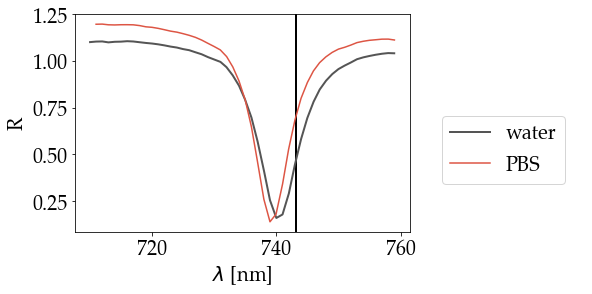

In [56]:
data, folder = data_about_master('L3')


plot_spectrum(data, folder)